# Apply Photometric Classification To Fit Results

This notebook applies the photometric classification method from González-Gaitán et al. 2014 to SDSS, DES, and CSP light-curve fits. Results are then used to analyze the properties of peculiar supernovae.

In [1]:
from os import path

import numpy as np
import pandas as pd
from astropy.table import Table, join
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.palettes import Category20
from matplotlib import pyplot as plt
from sklearn.utils import resample


## Load Data

We begin by reading in SNCosmo fit results for SDSS, DES, and CSP. This includes fits that use all observed bands, along with those that use exclusively the restframe blue and restframe red filters.

In [2]:
def get_fit_results(survey, model):
    """"""

    index_col = 1 if survey == 'sdss' else 0
    path_pattern = f'../sncosmo_fits/{survey}_results/{model}_{{}}.csv'
    
    all_data = pd.read_csv(path_pattern.format('all'), index_col=index_col)
    blue_data = pd.read_csv(path_pattern.format('blue'), index_col=index_col)
    red_data = pd.read_csv(path_pattern.format('red'), index_col=index_col)
    return all_data.dropna(), blue_data.dropna(), red_data.dropna()


sdss_snia_all, sdss_snia_blue, sdss_snia_red = get_fit_results('sdss', 'salt_2_4')
sdss_91bg_all, sdss_91bg_blue, sdss_91bg_red = get_fit_results('sdss', 'nugent')

des_snia_all, des_snia_blue, des_snia_red = get_fit_results('des', 'salt_2_4')
des_91bg_all, des_91bg_blue, des_91bg_red = get_fit_results('des', 'nugent')

csp_snia_all, csp_snia_blue, csp_snia_red = get_fit_results('csp', 'salt_2_4')
csp_91bg_all, csp_91bg_blue, csp_91bg_red = get_fit_results('csp', 'nugent')


Next, we calculate the difference in normalized chi-squared values and plot the results. The resulting plot is simpler to Figure 3 in the 2014 paper.

In [3]:
def calc_chisquared_diff(snia_blue, snia_red, bg_blue, bg_red):
    # Combine data tables for snia and 91bg templates
    combined_snia = snia_blue.join(snia_red, lsuffix='_blue', rsuffix='_red')
    combined_snia['chi_norm_blue'] = combined_snia['chi_blue'] / combined_snia['dof_blue']
    combined_snia['chi_norm_red'] = combined_snia['chi_red'] / combined_snia['dof_red']
    
    combined_91bg = bg_blue.join(bg_red, lsuffix='_blue', rsuffix='_red')
    combined_91bg['chi_norm_blue'] = combined_91bg['chi_blue'] / combined_91bg['dof_blue']
    combined_91bg['chi_norm_red'] = combined_91bg['chi_red'] / combined_91bg['dof_red']
    
    # Calculate chi-squared differences
    chi_squared_values = pd.DataFrame({
        'blue': combined_snia['chi_norm_blue'] - combined_91bg['chi_norm_blue'],
        'red': combined_snia['chi_norm_red'] - combined_91bg['chi_norm_red']
    })
    
    return chi_squared_values.dropna()


sdss_chi_diff = calc_chisquared_diff(sdss_snia_blue, sdss_snia_red, sdss_91bg_blue, sdss_91bg_red)
des_chi_diff = calc_chisquared_diff(des_snia_blue, des_snia_red, des_91bg_blue, des_91bg_red)
csp_chi_diff = calc_chisquared_diff(csp_snia_blue, csp_snia_red, csp_91bg_blue, csp_91bg_red)


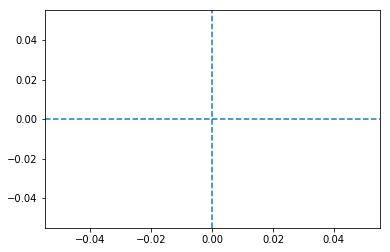

In [4]:
plt.scatter(sdss_chi_diff['blue'], sdss_chi_diff['red'])
plt.scatter(des_chi_diff['blue'], des_chi_diff['red'])
plt.scatter(csp_chi_diff['blue'], csp_chi_diff['red'])

plt.axhline(0, linestyle='--')
plt.axvline(0, linestyle='--')

plt.show()


We expect 91bg like supernovae to fall in the upper-right quadrant of the figure. Here we have drawn dashed lines intersecting at (0, 0) for visual reference only. A new set of lines will be generated later on to indicate a more carefully chosen selection of 91bg like supernovae.

# Optimize FOM

In [8]:
csp_spec_class = Table.read('./csp_classifications.txt', format='ascii')
csp_spec_class.keep_columns(['SN', 'Type'])
csp_spec_class.rename_column('Type', 'type')

# Remove rows without data or targets with inconclusive classifications
csp_spec_class.remove_rows([0, 1])
is_data = np.logical_not(csp_spec_class['type'] == '        ')
csp_spec_class = csp_spec_class[is_data]

csp_spec_class = csp_spec_class.to_pandas()
csp_spec_class = csp_spec_class.join(sdss_chi_diff)

csp_spec_class.head()


,SN,type,blue,red
0,2004dt,Normal,NaN,NaN
1,2004ef,Normal,NaN,NaN
2,2004eo,Normal,NaN,NaN
3,2004ey,Normal,NaN,NaN
4,2004gc,Normal,NaN,NaN


In [ ]:
def calc_fom(dataframe, blue_cutoff, red_cutoff):
    """Calculate the figure of merrit for a set of classifications

    FOM = (num_true / num_tot) X (num_true / (num_true + num_false))
    
    args:
        num_tot   (float): Total input number of that type
        num_true  (float): Number of correct classifications for a given type
        num_false (float): Number of objects falsely classified for that type
        
    Returns:
        The figure of merit value
    """
    
    is_91bg_true = dataframe['type'] == '91bg'
    is_91bg_classified = (
        (dataframe['blue'] > blue_cutoff)
        & (dataframe['red'] > red_cutoff)
    )

    num_tot = sum(is_91bg_true)  # How to handle multiple types?
    num_true = sum(is_91bg_true == is_91bg_classified)
    num_false = len(dataframe) - num_true
    return (num_true / num_tot) * (num_true / (num_true + num_false))

calc_fom(csp_spec_class, 0, 0)


## Bootstrap

In [ ]:
# configure bootstrap
n_iterations = 1000
n_size = int(len(data) * 0.50)

# run bootstrap
fom_values = []
for i in range(n_iterations):
    # prepare train and test sets
    sample_data = resample(values, n_samples=n_size)
    fom_values.append(optimize_fom(sample_data))

# confidence intervals
alpha = 0.95
p = ((1 - alpha) / 2) * 100
lower = max(0, numpy.percentile(stats, p))
p = (alpha + ((1 - alpha) / 2)) * 100
upper = min(1.0, numpy.percentile(stats, p))
print(f'{alpha*100:.1f} confidence interval {lower*100:.1f} and {upper*100:.1f}')
